In [20]:
import sys

print(sys.path)
sys.path.append("../../")

['/home/filippo/GarbageDetectionAndSegmentation/notebooks/demo', '/usr/lib64/python310.zip', '/usr/lib64/python3.10', '/usr/lib64/python3.10/lib-dynload', '', '/home/filippo/.local/lib/python3.10/site-packages', '/usr/lib64/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '../../', '../../']


In [21]:
!pip install -r "../../requirements.txt"

Defaulting to user installation because normal site-packages is not writeable


In [22]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import imageio.v3 as iio
import joblib

import imgaug as ia
import imgaug.augmenters as iaa

import random as rand
import numpy as np 
import cv2
import glob
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import convert, show_images
from featuresourcer import HogFeatureExtractor, CannyFeatureExtractor

## Choose the features you wish to extract

In [23]:
features = "canny" # possible values: hog, canny

## Set the parameters specific for the features

In [24]:
#start_frame = iio.imread("../../data/train/positive/paper/paper1.jpg")
if features == "canny":
    sourcer_params = {
      'color_model': 'hls',                
      'bounding_box_w': 64,             
      'bounding_box_h' : 48,
      'first_thresh': 10,             
      'second_thresh' : 200,
    }
    sourcer = CannyFeatureExtractor(sourcer_params)
elif features == "hog":
    sourcer_params = {
      'color_model': 'hls',                
      'bounding_box_w': 64,             
      'bounding_box_h' : 48,
      'number_of_orientations': 12,        
      'pixels_per_cell': 8,               
      'cells_per_block': 2,                
      'do_transform_sqrt': True
    }
    sourcer = HogFeatureExtractor(sourcer_params)

## Augment training images

In [25]:
print("Loading images to memory...")
t_start = time.time()

garbage_imgs, nongarbage_imgs = [], []
garbage_paths = glob.glob('../../data/train/positive/*/*.jpg')
nongarbage_paths = glob.glob('../../data/train/negative/*/*.jpg')

for path in garbage_paths: garbage_imgs.append(iio.imread(path))
for path in nongarbage_paths: nongarbage_imgs.append(iio.imread(path))
random.shuffle(nongarbage_imgs)
nongarbage_imgs = nongarbage_imgs[:10000] # i take only 10,000 random images among all the almost 70,000 available

garbage_imgs, nongarbage_imgs = np.asarray(garbage_imgs), np.asarray(nongarbage_imgs)
print("... Done")
print("Time Taken:", np.round(time.time() - t_start, 2))
print("Garbage images shape: ", garbage_imgs.shape)
print("Non-garbage images shape: ", nongarbage_imgs.shape)

Loading images to memory...
... Done
Time Taken: 15.37
Garbage images shape:  (2575, 48, 64, 3)
Non-garbage images shape:  (10000, 48, 64, 3)


In [26]:
#garbage_imgs = np.repeat(garbage_imgs, 8,axis=1)
garbage_imgs = np.tile(garbage_imgs,(4,1,1,1))
#garbage_imgs = np.array((iio.imread("/home/filippo/GarbageDetectionAndSegmentation/data/train/positive/plastic/plastic49.jpg"),iio.imread("/home/filippo/GarbageDetectionAndSegmentation/data/train/positive/plastic/plastic49.jpg"),iio.imread("/home/filippo/GarbageDetectionAndSegmentation/data/train/positive/plastic/plastic49.jpg"),iio.imread("/home/filippo/GarbageDetectionAndSegmentation/data/train/positive/plastic/plastic49.jpg")))
print(garbage_imgs.shape)
#nongarbage_imgs = np.repeat(nongarbage_imgs, 8)

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
"""images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)"""

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

garbage_imgs = seq(images=garbage_imgs)
#nongarbage_imgs = seq(images=nongarbage_imgs)

(4, 48, 64, 3)


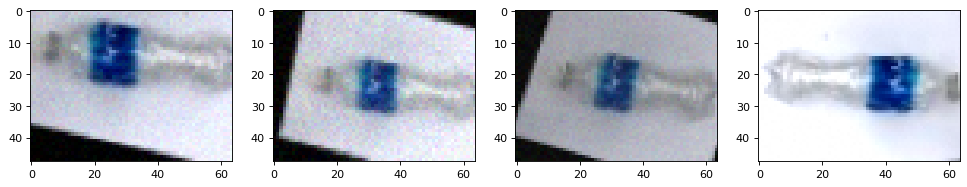

In [28]:
    fig, ax = plt.subplots(1, 4, figsize = (15, 8), dpi = 80)
    ax = ax.ravel()
    ax[0].imshow(garbage_imgs[0])
    ax[1].imshow(garbage_imgs[1])
    ax[2].imshow(garbage_imgs[2])
    ax[3].imshow(garbage_imgs[3])

## Train the classifier

In [8]:
total_garbage, total_nongarbage = garbage_imgs.shape[0], nongarbage_imgs.shape[0]


print("Extracting features... This might take a while...")
t_start = time.time()

garbage_features, nongarbage_features = [], []

print("Garbage...")
for img in garbage_imgs:
  garbage_features.append(sourcer.features(img))
  print('█', end = '')

print()
print("Non-Garbage...")
for img in nongarbage_imgs:
  nongarbage_features.append(sourcer.features(img))
  print('█', end = '')
                         
garbage_features = np.asarray(garbage_features)
nongarbage_features = np.asarray(nongarbage_features)

print()
print("...Done")
print("Time Taken:", np.round(time.time() - t_start, 2))
print("Garbage features shape: ", garbage_features.shape)
print("Non-Garbage features shape: ", nongarbage_features.shape)

print("Scaling features...")
t_start = time.time()
print(" GARBAGE SHAPE ",garbage_features.dtype)
print(" NONGARBAGE SHAPE ", nongarbage_features.dtype)
unscaled_x = np.vstack((garbage_features, nongarbage_features)).astype(np.float64)
scaler = StandardScaler().fit(unscaled_x)
x = scaler.transform(unscaled_x)
y = np.hstack((np.ones(total_garbage), np.zeros(total_nongarbage)))

print("...Done")
print("Time Taken:", np.round(time.time() - t_start, 2))
print(" x shape: ", x.shape, " y shape: ", y.shape)

print("Training classifier...")
t_start = time.time()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                    random_state = rand.randint(1, 100))
svc = LinearSVC()
svc.fit(x_train, y_train)
accuracy = svc.score(x_test, y_test)

print("...Done")
print("Time Taken:", np.round(time.time() - t_start, 2))
print("Accuracy: ", np.round(accuracy, 4))

Extracting features... This might take a while...
Garbage...


████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

/home/filippo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Save model

In [9]:
print ("Saving models...")

joblib.dump(svc, '../../saved_models/'+features+'_svc.pkl')
joblib.dump(scaler, '../../saved_models/'+features+'_scaler.pkl')

print("...Done")

Saving models...
...Done


## Load model

In [10]:
print ("Loading models...")

model = joblib.load('../../saved_models/'+features+'_svc.pkl')
scaler = joblib.load('../../saved_models/'+features+'_scaler.pkl')

print("...Done")

Loading models...
...Done
